# Implement arbitrary boundary conditions with discrete fourier transforms using shift function 

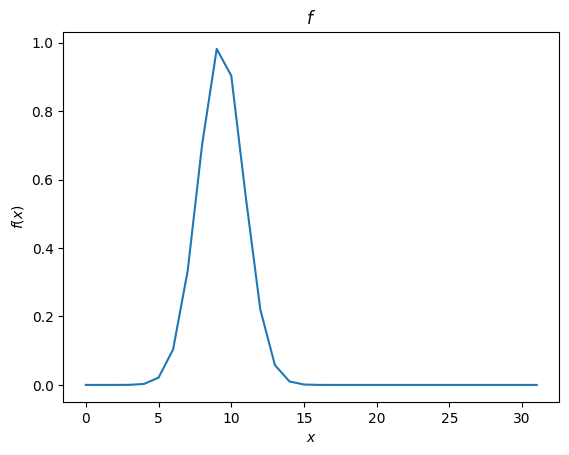

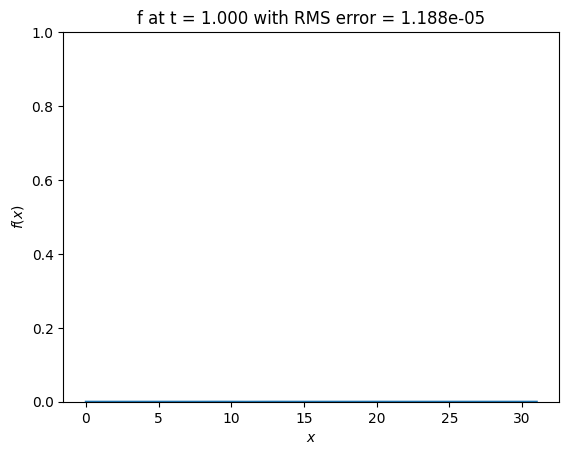

In [61]:
import spectral_derivative as sd
import numpy as np 
import matplotlib.pyplot as plt

L                 = 1
N                 = 32
x                 = np.linspace(0, L, N)
dx                = x[1] - x[0]
dt                = 1e-4
v                 = 1
t                 = 0.0
tend              = 1.0
r                 = (v * dt)**2
ghostBoundary     = 8
fdl               = 0
fdr               = 0
BC                = sd.PERIODIC
mode              = sd.M_POLYNOMIAL
derivativeMode    = sd.ONE_SIDED
smoothingOrder    = 5
def func(x, v, t):
    return np.exp(-(x-0.3 - t * v)**2/0.005)

f  = func(x, v, t    )
fm = func(x, v, t - dt)

plt.title(r"$f$")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

while t < tend:
    #Fill ghost zone of length ghost boundary with boundary conditions
    for i in range(ghostBoundary + 1): 
        f[     i] = func(     i * dx, v, t)
        f[-1 - i] = func( L - i * dx, v, t)

    #Create shift function that such that f - B fulfills either Dirichlet, Neumann or periodic boundary conditions depending on mode
    B, poly = sd.getShiftFunction(x, f, mode, derivativeMode, lb = fdl, rb = fdr, N = smoothingOrder, debug= False)

    #Boundary for finite difference stencil
    lind =          fdl
    rind = len(x) - fdr 
    
    #Subtract linear shift function to enforce Dirichlet BC when computing second derivative
    homf            = f[ lind : rind ] - B[0]
    homf            = np.pad(homf, (0, 1), mode="constant")
    p, ind1, ind2   = sd.selectBC       (homf, BC)
    ddf, k          = sd.laplacianDtt1D (p, dx, BC, debug= False)
    ddf             = ddf.real
    #ddf             = sd.restoreBC      (ddf, BC).real
    if B.shape[0] > 1:
        ddf             = ddf + B[1]
        
    fp                  = 2 * f [ lind : rind ] - fm [ lind : rind ] + r * ddf
    fm [ lind : rind ]  = f [ lind : rind ]
    f  [ lind : rind ]  = fp
    t += dt 

plt.title(f"f at t = {t:3.3f} with RMS error = {np.mean(np.abs(f - func(x, v, t))):3.3e}")
plt.plot(f)
plt.ylim([0, 1])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

## Use an additional window

[0.         0.04951557 0.1882551  0.38873953 0.61126047 0.8117449
 0.95048443 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.95048443 0.8117449  0.61126047 0.38873953 0.1882551
 0.04951557 0.        ]


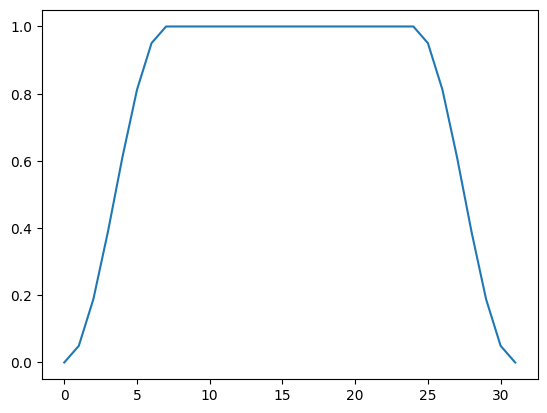

In [51]:

def absorbingPotential(x, L0_phys, L0_buf, L1_phys, L1_buf):
    y = np.zeros(x.shape)

    delta = L1_buf - L1_phys
    
    y[x <= L0_phys] = np.cos( np.pi * (x[x <= L0_phys] - L0_buf) / ( 2 * delta ) )**2
    y[x >= L1_phys] = np.cos( np.pi * (x[x >= L1_phys] - L1_buf) / ( 2 * delta ) )**2
    return y

V = absorbingPotential(x, (ghostBoundary - 1)*dx, 0, L - (ghostBoundary -1 ) * dx, 1) 

plt.plot(1-V)
print(1-V)

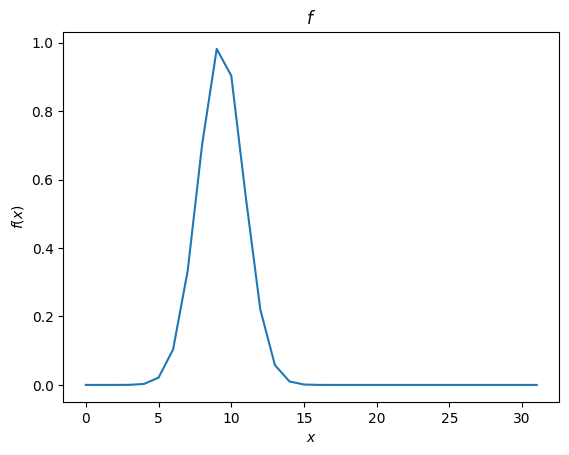

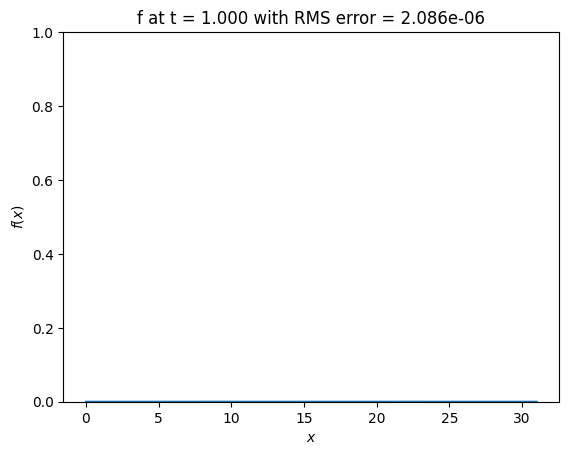

In [74]:
t = 0
f  = func(x, v, t    )
fm = func(x, v, t - dt)

plt.title(r"$f$")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()
m = 100
while t < tend:
    #Fill ghost zone of length ghost boundary with boundary conditions
    for i in range(ghostBoundary + 1): 
        f[     i] = func(     i * dx, v, t)
        f[-1 - i] = func( L - i * dx, v, t)

    #Create shift function that such that f - B fulfills either Dirichlet, Neumann or periodic boundary conditions depending on mode
    B, poly = sd.getShiftFunction(x, f, mode, derivativeMode, lb = fdl, rb = fdr, N = 10, debug= False)

    #Boundary for finite difference stencil
    lind =          fdl
    rind = len(x) - fdr 
    
    #Subtract linear shift function to enforce Dirichlet BC when computing second derivative
    homf            = f[ lind : rind ] - B[0]
    homf            = homf * (1 - V) + homf * V * np.exp(-m * dt)
    homf            = np.pad(homf, (0, 1), mode="constant")
    p, ind1, ind2   = sd.selectBC       (homf, BC)
    ddf, k          = sd.laplacianDtt1D (p, dx, BC, debug= False)
    ddf             = ddf.real

    if B.shape[0] > 1:
        ddf             = ddf + B[1]
        
    fp                  = 2 * f [ lind : rind ] - fm [ lind : rind ] + r * ddf
    fm [ lind : rind ]  = f [ lind : rind ]
    f  [ lind : rind ]  = fp
    t += dt 

plt.title(f"f at t = {t:3.3f} with RMS error = {np.mean(np.abs(f - func(x, v, t))):3.3e}")
plt.plot(f)
plt.ylim([0, 1])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

Result:
- Windows do not provide better performance than polynomial subtraction
- Similar to Bell function

## Use a bell function

In [54]:
import scipy 

# Asymptotic Fourier Coefficients for a C ∞ Bell
#(Smoothed-“Top-Hat”) & the Fourier Extension
#Problem
#John P. Boyd 1

#Eq. 2
def erflike(x, L):
    if x <= -1:
        return -1
    elif x >= 1:
        return  1
    else:
        return scipy.special.erf(L * x / np.sqrt(1 - x**2))

#Eq. 3
def ramp(x, L):
    return 0.5 * (1 + erflike(x, L))

#Eq. 5
def bell(x, L, chi, psi): 
#   Eq. 4
    Omega = (psi - chi) / 2
    if -psi <= x and x < -chi: 
        return ramp(+(x + chi + Omega)/Omega, L)
    elif -chi <= x and x <= chi: 
        return 1
    else:
        return ramp(-(x - chi - Omega)/Omega, L)
    

def shiftx(x):
    dx = x[1] - x[0]
    a  = x[0]
    b  = x[-1]
    return  (x - (a + b)/2)/ ((b - a)/2)


### A plot of the Bell function

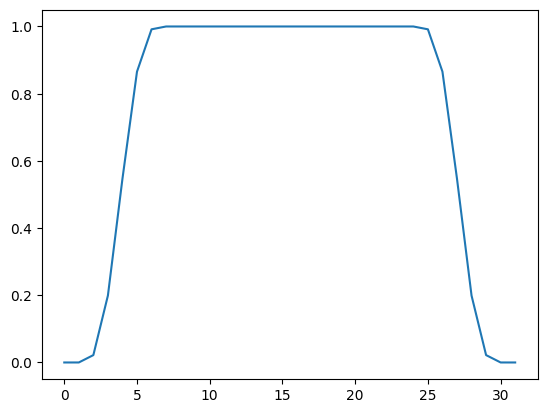

array([0.00000000e+00, 2.76042645e-05, 2.19631017e-02, 1.99151946e-01,
       5.46811499e-01, 8.65539965e-01, 9.91568838e-01, 9.99999665e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       9.99999665e-01, 9.91568838e-01, 8.65539965e-01, 5.46811499e-01,
       1.99151946e-01, 2.19631017e-02, 2.76042645e-05, 0.00000000e+00])

In [64]:

chi = 1
psi = 2
cx = 0.911 * np.sqrt(1 - chi/psi) * np.sqrt(len(x)/2)
bf  = np.array([bell(r, cx, chi, psi) for r in shiftx(x)*2]) 
plt.plot(bf)    
plt.show() 
bf

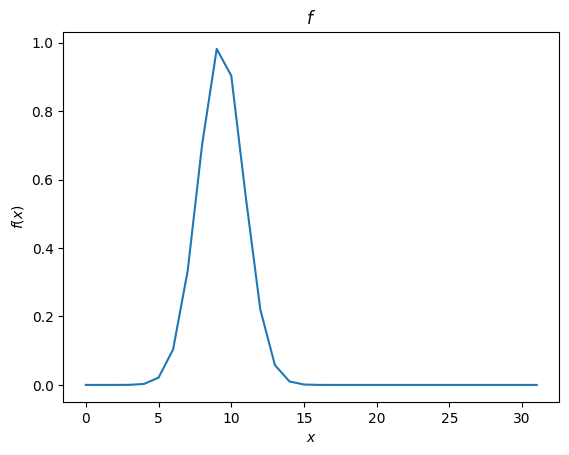

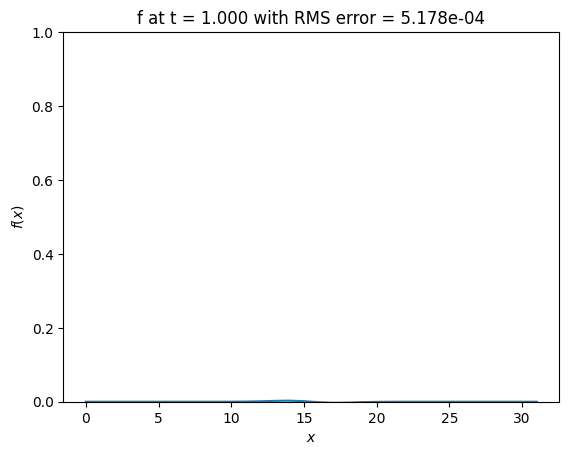

In [73]:
t = 0

f  = func(x, v, t    )
fm = func(x, v, t - dt)
smoothingOrder = 0

plt.title(r"$f$")
plt.plot(f)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

while t < tend:
    #Fill ghost zone of length ghost boundary with boundary conditions
    for i in range(ghostBoundary + 1): 
        f[     i] = func(     i * dx, v, t)
        f[-1 - i] = func( L - i * dx, v, t)

    #Create shift function that such that f - B fulfills either Dirichlet, Neumann or periodic boundary conditions depending on mode
    B, poly = sd.getShiftFunction(x, f, mode, derivativeMode, lb = fdl, rb = fdr, N = smoothingOrder, debug= False)

    #Boundary for finite difference stencil
    lind =          fdl
    rind = len(x) - fdr 
    
    #Subtract linear shift function to enforce Dirichlet BC when computing second derivative
    homf            = f[ lind : rind ] - B[0]
    homf            = homf * bf
    ddf, k          = sd.laplacianDtt1D (homf, dx, BC, debug= False)
    ddf             = ddf.real
    #ddf             = sd.restoreBC      (ddf, BC).real
    if B.shape[0] > 1:
        ddf             = ddf + B[1]
        
    fp                  = 2 * f [ lind : rind ] - fm [ lind : rind ] + r * ddf
    fm [ lind : rind ]  = f [ lind : rind ]
    f  [ lind : rind ]  = fp
    t += dt 

plt.title(f"f at t = {t:3.3f} with RMS error = {np.mean(np.abs(f - func(x, v, t))):3.3e}")
plt.plot(f)
plt.ylim([0, 1])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.show()

What we learn from this experiment is:
- Bells can provide an alternative to polynomial subtraction
- One cannot use them together with polynomial subtraction
- The reason is that they degrade the quality of the homogenised function